In [58]:
%load_ext autoreload

%autoreload 2
from multiprocessing import Pool
import matplotlib.pyplot as plt
import pickle
from astropy.coordinates import SkyCoord, match_coordinates_3d, match_coordinates_sky
import sys
import emcee
import numpy as np
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from astropy.table import Table, QTable, hstack, vstack
from astropy import units as u
import corner
from astropy.coordinates import SkyCoord, match_coordinates_3d
cosmo_astropy = FlatLambdaCDM(H0=71.0, Om0=0.265, Ob0 = 0.0448)
import iminuit
from iminuit import Minuit
cosmo_astropy.critical_density(0.4).to(u.Msun / u.Mpc**3).value

sys.path.append('/pbs/throng/lsst/users/cpayerne/CLMassDC2/modules/')
import CL_WL_miscentering as mis
import analysis_Mass_Richness_relation as analysis
import CL_WL_two_halo_term as twoh
import CL_WL_mass_conversion as utils
import CL_DATAOPS_match_catalogs as match
import CL_WL_DATAOPS_make_profile as prf
#import CL_Likelihood_for_Mass_richness_relation as mass_richness
#import CL_fiducial_mass_richness_relation as fiducial
#import analysis_Mass_richness_relation as analysis


import clmm
import clmm.dataops
from clmm.dataops import compute_tangential_and_cross_components, make_radial_profile, make_bins
from clmm.galaxycluster import GalaxyCluster
import clmm.utils as u
import astropy.units as un
from clmm import Cosmology
from clmm.support import mock_data as mock
import pyccl as ccl

cosmo = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
cosmo_astropy = FlatLambdaCDM(H0=71.0, Om0=0.265, Ob0 = 0.0448)
cosmo_clmm = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
cosmo_ccl  = ccl.Cosmology(Omega_c=0.265-0.0448, Omega_b=0.0448, h=0.71, A_s=2.1e-9, n_s=0.96, Neff=0, Omega_g=0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
def load(filename, **kwargs):
    with open(filename, 'rb') as fin:
        return pickle.load(fin, **kwargs)

In [60]:
ind_profile = np.load('/pbs/throng/lsst/users/cpayerne/CLMassDC2//data/data_new_version/ind_profile_redmapper.pkl', allow_pickle = True)
ind_profile['cluster_id'] = ind_profile['id']

In [61]:
data = np.load('/pbs/throng/lsst/users/cpayerne/CLMassDC2/notebooks/data_for_notebooks/stacked_esd_profiles_redmapper_BPZ.pkl', allow_pickle=True)
profiles = data['stacked profile']
covariances = data['stacked covariance']

In [62]:
len(profiles)

16

In [63]:
Z_bin = analysis.Z_bin
Obs_bin = analysis.Obs_bin

In [64]:
Z_bin, Obs_bin

([[0.2, 0.35], [0.35, 0.5], [0.5, 0.65], [0.65, 0.8]],
 [[20.0, 45.0], [45.0, 70.0], [70.0, 95.0], [95.0, 120.0]])

In [65]:
len(covariances), len(profiles)

(16, 16)

In [66]:
import CL_Mass_richness_relation as mr
import CL_Likelihood_for_Mass_richness_relation_v2 as likelihood_mr
MR_modeling = mr.WL_Mass_Richness()
MR_modeling.set_pivot_values(analysis.z0, analysis.richness0)

4 4


/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt


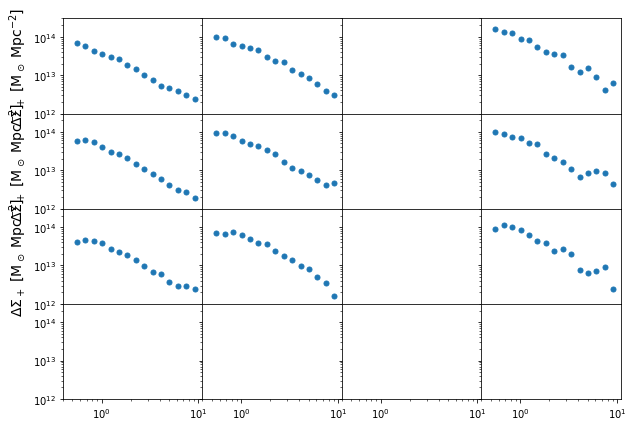

In [57]:
n_z_bin = len(Z_bin) 
n_m_bin = len(Obs_bin) 
print(n_z_bin, n_m_bin)
scale = 3
fig, axs = plt.subplots( n_z_bin, n_m_bin, figsize = (10,7), sharex = True, sharey = True)
fig.subplots_adjust(wspace=0, hspace=0)
for i, z_bin in enumerate(Z_bin):

    for j, m_bin in enumerate(Obs_bin):
        try:

            if i >= n_m_bin: continue

            mask_z = (profiles['z_mean'] > z_bin[0])*(profiles['z_mean'] < z_bin[1])
            mask_m = (profiles['obs_mean'] > m_bin[0])*(profiles['obs_mean'] < m_bin[1])
            index = np.arange(len(profiles))
            index_cut = index[mask_m * mask_z]
            f_cut = profiles[index_cut]
            cov = np.array(covariances['cov_t'][index_cut])

            err = cov.diagonal()**.5


            axs[i, j].errorbar(f_cut['radius'][0], f_cut['gt'][0] 
                               #err,  c = 'k'
                               ,marker = 'o',fmt = ' ', elinewidth = 2, capsize = 5, markersize = 5, markerfacecolor = None)
            #r=np.linspace(1, 5.5, 100)
            #lnM = MR_modeling.lnM(f_cut['obs_mean'][0], f_cut['z_mean'][0], [14.13190028, -0.71776671,  0.7400713 ])
            #print(lnM)
            #y = clmm.compute_excess_surface_density(r, np.exp(lnM), 4, f_cut['z_mean'][0], cosmo, delta_mdef=200,
            #                               halo_profile_model='nfw', massdef='critical')     
            #axs[i, j].plot(r,y)
            axs[i, j].set_ylim(1e12, 3e14)
            axs[i, j].set_xlim(0.4, 11)
            axs[i, j].set_xscale('log')
            axs[i, j].set_yscale('log')
           # axs[i, j].legend(frameon = False, loc = 'upper right', fontsize = 10)
            axs[i, j].set_xlabel('R [Mpc]', fontsize = 20)
            axs[i, j].set_ylabel(r'$\Delta\Sigma_+$ ' +'$[$' + r'${\rm M}$' + r'$_\odot\;$'+ r'${\rm Mpc}$'+r'$^{-2}$'r'$]$', fontsize = 14)
        except: a=1

for ax in fig.get_axes():
    ax.label_outer()